In [13]:
import matplotlib as mpl

import os
import glob
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.colors as mcolors

import utils as util
import process_datafiles as procd

import assign_phase as ph
import scipy.stats as spstats

from scipy.optimize import curve_fit
import scipy

In [1013]:
import functools
import scipy.optimize
from scipy.special import erf


def mle_fit_psycho(data, p_model='weibull', parstart=None, parmin=None, parmax=None, nfits=5):
    """
    https://github.com/cortex-lab/psychofit/blob/master/psychofit.py
    Maximumum likelihood fit of psychometric function.
    Args:
        data: 3 x n matrix where first row corresponds to stim levels,
              the second to number of trials for each stim level (int),
              the third to proportion correct / proportion rightward (float between 0 and 1)
        p_model: The psychometric function. Possibilities include 'weibull'
                 (DEFAULT), 'weibull50', 'erf_psycho' and 'erf_psycho_2gammas'
        parstart: Non-zero starting parameters, used to try to avoid local minima.
                  The parameters are [threshold, slope, gamma], or if using the
                  'erf_psycho_2gammas' model append a second gamma value.
                  Recommended to use a value > 1. If None, some reasonable defaults are used.
        parmin: Minimum parameter values.  If None, some reasonable defaults are used
        parmax: Maximum parameter values.  If None, some reasonable defaults are used
        nfits: The number of fits
    Returns:
        pars: The parameters from the best of the fits
        L: The likelihood of the best fit
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix
    Examples:
        Below we fit a Weibull function to some data:
        >>> import numpy as np
        >>> import matplotlib.pyplot as plt
        >>> cc = np.array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]) # contrasts
        >>> nn = np.full((9,), 10) # number of trials at each contrast
        >>> pp = np.array([5., 8., 20., 41., 54., 59., 79., 92., 96])/100 # proportion "rightward"
        >>> pars, L = mle_fit_psycho(np.vstack((cc, nn, pp)), 'erf_psycho')
        >>> plt.plot(cc, pp, 'bo', mfc='b')
        >>> plt.plot(np.arange(-8, 8, 0.1), erf_psycho(pars, np.arange(-8, 8, 0.1)), '-b')
    Information:
        1999-11 FH wrote it
        2000-01 MC cleaned it up
        2000-04 MC took care of the 50% case
        2009-12 MC replaced fmins with fminsearch
        2010-02 MC, AZ added nfits
        2013-02 MC+MD fixed bug with dealing with NaNs
        2018-08 MW ported to Python
    """
    # Input validation
    if isinstance(data, (list, tuple)):
        data = np.array(data)
    elif not isinstance(data, np.ndarray):
        raise TypeError('data must be a list or numpy array')

    if data.shape[0] != 3:
        raise ValueError('data must be m by 3 matrix')
        
    # parstart = np.array([np.mean(data[0, :]), 0.5, (0.5)])
    # parmin = np.array([np.min(data[0, :]), 0.0, (0.)])
    # parmax = np.array([np.max(data[0, :]), 10., (0.5)])
    
    start_gamma = 0.5
    min_gamma=0.
    max_gamma=1.0
    #rep = lambda x: (x, x) if p_model.endswith('2gammas') else (x,)
    if parstart is None:
        parstart = np.array([np.mean(data[0, :]), 0.5, start_gamma, start_gamma]) if '2gammas' in p_model \
                    else np.array([np.mean(data[0, :]), 0.5, start_gamma])
    if parmin is None:
        parmin = np.array([np.min(data[0, :]), 0.0, min_gamma, min_gamma]) if '2gammas' in p_model \
                    else np.array([np.min(data[0, :]), 0.0, min_gamma])
    if parmax is None:
        parmax = np.array([np.max(data[0, :]), 10., max_gamma, max_gamma]) if '2gammas' in p_model \
                    else np.array([np.max(data[0, :]), 10., max_gamma])
        
    # find the good values in pp (conditions that were effectively run)
    ii = np.isfinite(data[2, :])

    likelihoods = np.zeros(nfits,)
    pars = np.empty((nfits, parstart.size))

    f = functools.partial(neg_likelihood, data=data[:, ii],
                          p_model=p_model, parmin=parmin, parmax=parmax)
    for ifit in range(nfits):
        pars[ifit, :] = scipy.optimize.fmin(f, parstart, disp=False)
        parstart = parmin + np.random.rand(parmin.size) * (parmax-parmin)
        likelihoods[ifit] = -neg_likelihood(pars[ifit, :], data[:, ii], p_model, parmin, parmax)

    # the values to be output
    L = likelihoods.max()
    iBestFit = likelihoods.argmax()
    return pars[iBestFit, :], L

def neg_likelihood(pars, data, p_model='weibull', parmin=None, parmax=None):
    """
    Negative likelihood of a psychometric function.
    Args:
        pars: Model parameters [threshold, slope, gamma], or if
              using the 'erf_psycho_2gammas' model append a second gamma value.
        data: 3 x n matrix where first row corresponds to stim levels,
              the second to number of trials for each stim level (int),
              the third to proportion correct / proportion rightward (float between 0 and 1)
        p_model: The psychometric function. Possibilities include 'weibull'
                 (DEFAULT), 'weibull50', 'erf_psycho' and 'erf_psycho_2gammas'
        parmin: Minimum bound for parameters.  If None, some reasonable defaults are used
        parmax: Maximum bound for parameters.  If None, some reasonable defaults are used
    Returns:
        l: The likelihood of the parameters.  The equation is:
            - sum(nn.*(pp.*log10(p_model)+(1-pp).*log10(1-p_model)))
            See the the appendix of Watson, A.B. (1979). Probability
            summation over time. Vision Res 19, 515-522.
    Raises:
        ValueError: invalid model, options are "weibull",
                    "weibull50", "erf_psycho" and "erf_psycho_2gammas"
        TypeError: data must be a list or numpy array
        ValueError data must be m by 3 matrix
    Information:
        1999-11 FH wrote it
        2000-01 MC cleaned it up
        2000-07 MC made it indep of Weibull and added parmin and parmax
        2018-08 MW ported to Python
    """
    # Validate input
    if isinstance(data, (list, tuple)):
        data = np.array(data)
    elif not isinstance(data, np.ndarray):
        raise TypeError('data must be a list or numpy array')

    if parmin is None:
        parmin = np.array([.005, 0., 0.])
    if parmax is None:
        parmax = np.array([10, 1, .25])

    if data.shape[0] == 3:
        xx = data[0, :]
        nn = data[1, :]
        pp = data[2, :]
    else:
        raise ValueError('data must be m by 3 matrix')

    # here is where you effectively put the constraints.
    if (any(pars < parmin)) or (any(pars > parmax)):
        l = 10000000
        return l

    dispatcher = {
        'weibull': weibull,
        'weibull50': weibull50,
        'erf_psycho': erf_psycho,
        'erf_psycho_2gammas': erf_psycho_2gammas
    }
    try:
        probs = dispatcher[p_model](pars, xx)
    except KeyError:
        raise ValueError('invalid model, options are "weibull", ' +
                         '"weibull50", "erf_psycho" and "erf_psycho_2gammas"')

    assert (max(probs) <= 1) or (min(probs) >= 0), 'At least one of the probabilities is not ' \
                                                   'between 0 and 1'

    probs[probs == 0] = np.finfo(float).eps
    probs[probs == 1] = 1 - np.finfo(float).eps

    l = - sum(nn * (pp * np.log(probs) + (1 - pp) * np.log(1 - probs)))
    return l


def weibull(pars, xx):
    """
    Weibull function from 0 to 1, with lapse rate.
    Args:
        pars: Model parameters [alpha, beta, gamma].
        xx: vector of stim levels.
    Returns:
        A vector of length xx
    Raises:
        ValueError: pars must be of length 3
        TypeError: pars must be list-like or numpy array
    Information:
        1999-11 FH wrote it
        2000-01 MC cleaned it up
        2018-08 MW ported to Python
    """
    # Validate input
    if not isinstance(pars, (list, tuple, np.ndarray)):
        raise TypeError('pars must be list-like or numpy array')

    if len(pars) != 3:
        raise ValueError('pars must be of length 3')

    alpha, beta, gamma = pars
    return (1 - gamma) - (1 - 2*gamma) * np.exp(-((xx / alpha)**beta))


def weibull50(pars, xx):
    """
    Weibull function from 0.5 to 1, with lapse rate.
    Args:
        pars: Model parameters [alpha, beta, gamma].
        xx: vector of stim levels.
    Returns:
        A vector of length xx
    Raises:
        ValueError: pars must be of length 3
        TypeError: pars must be list-like or numpy array
    Information:
        2000-04 MC wrote it
        2018-08 MW ported to Python
    """
    # Validate input
    if not isinstance(pars, (list, tuple, np.ndarray)):
        raise TypeError('pars must be list-like or numpy array')

    if len(pars) != 3:
        raise ValueError('pars must be of length 3')

    alpha, beta, gamma = pars
    return (1 - gamma) - (.5 - gamma) * np.exp(-((xx / alpha) ** beta))


def erf_psycho(pars, xx):
    """
    erf function from 0 to 1, with lapse rate.
    Args:
        pars: Model parameters [bias, slope, lapse].
        xx: vector of stim levels.
    Returns:
        ff: A vector of length xx
    Examples:
        >>> import numpy as np
        >>> import matplotlib.pyplot as plt
        >>> xx = np.arange(-50, 50)
        >>> ff = erf_psycho(np.array([-10., 10., 0.1]), xx)
        >>> plt.plot(xx, ff)
    Raises:
        ValueError: pars must be of length 3
        TypeError: pars must be a list or numpy array
    Information:
        2000    MC wrote it
        2018-08 MW ported to Python
    """
    # Validate input
    if not isinstance(pars, (list, tuple, np.ndarray)):
        raise TypeError('pars must be list-like or numpy array')

    if len(pars) != 3:
        raise ValueError('pars must be of length 4')

    (bias, slope, gamma) = pars
    return gamma + (1 - 2 * gamma) * (erf((xx - bias) / slope) + 1) / 2


def erf_psycho_2gammas(pars, xx):
    """
    erf function from 0 to 1, with two lapse rates.
    Args:
        pars: Model parameters [bias, slope, gamma].
        xx: vector of stim levels (%)
    Returns:
        ff: A vector of length xx
    Examples:
        >>> import numpy as np
        >>> import matplotlib.pyplot as plt
        >>> xx = np.arange(-50, 50)
        >>> ff = erf_psycho_2gammas(np.array([-10., 10., 0.2, 0.]), xx)
        >>> plt.plot(xx, ff)
    Raises:
        ValueError: pars must be of length 4
        TypeError: pars must be list-like or numpy array
    Information:
        2000    MC wrote it
        2018-08 MW ported to Python
    """
    # Validate input
    if not isinstance(pars, (list, tuple, np.ndarray)):
        raise TypeError('pars must be a list-like or numpy array')

    if len(pars) != 4:
        raise ValueError('pars must be of length 4')

    (bias, slope, gamma1, gamma2) = pars
    return gamma1 + (1 - gamma1 - gamma2) * (erf((xx - bias) / slope) + 1) / 2


# Meta info

In [3]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')
metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


# Experiment 

In [20]:
reload(procd)

<module 'process_datafiles' from 'process_datafiles.py'>

In [54]:
#### Get all animals in specified cohorts
cohort_list = ['AG', 'AN']
# cohort_list = ['AG', 'AJ']
excluded_animals = []
cohortdf = procd.combine_cohorts_to_dataframe(metadata, cohorts=cohort_list)

('combining data from 2 cohorts:', ['AG', 'AN'])
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df


process_datafiles.py:216: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dflist, axis=0).reset_index(drop=True)


In [55]:
_ = ph.print_phase_lookup()

{   -1: 'other',
    0: 'always_reward',
    1: 'default',
    2: 'size',
    3: 'depth_rotation',
    4: 'cross',
    5: 'size_and_depth_rotation',
    6: 'depth_and_planar_rotation',
    7: 'morph',
    8: 'newstimuli',
    9: 'fine_grained_size',
    10: 'fine_grained_depth_rotation',
    11: 'fine_grained_size_and_depth_rotation',
    12: 'transparency',
    13: 'clutter',
    14: 'light_position',
    15: 'x_rotation',
    16: 'position',
    17: 'punishcycle_long',
    18: 'punishcycle_short',
    19: 'no_min_RT'}


In [56]:
#### Select phase to analyze
curr_phase = 7

#### Get data for current phase
df_ = []
for cohort in cohort_list: #['AL']:

    # Load phase info for cohort
    phaseinfo = ph.get_phase_data(cohort, create_new=False)

    # Get phase infor for current phase
    curr_phaseinfo =  phaseinfo[phaseinfo['phase']==curr_phase]
    print('Cohort %s: found phases' % cohort, phaseinfo['phase'].unique())

    # Get datafiles for current phase
    datafiles_in_phase = [s for s, g in curr_phaseinfo.groupby(['animalid', 'session', 'suffix'])]

    # Combine data for phase
    dlist = [g for s, g in cohortdf.groupby(['animalid', 'session', 'suffix']) if s in datafiles_in_phase]
    
    if len(dlist) > 0:
        tmpdf = pd.concat(dlist, axis=0).reset_index(drop=True)
        tmpdf['cohort'] = [cohort for _ in np.arange(0, len(tmpdf))]
        tmpdf['objectid'] = [str(i) for i in tmpdf['object']]
        df_.append(tmpdf)

df = pd.concat(df_, axis=0).reset_index(drop=True)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AG.pkl
('Cohort AG: found phases', array([16,  9, 10,  4,  5, 14, 15,  6, -1,  8,  1,  7]))
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AN.pkl
('Cohort AN: found phases', array([0, 1, 7]))


In [57]:
df.columns

Index([u'animalid', u'cohort', u'depth_rotation', u'duration',
       u'light_position', u'name', u'no_feedback', u'object', u'outcome',
       u'outcome_time', u'pos_x', u'pos_y', u'response', u'response_time',
       u'rotation', u'session', u'sessionid', u'size', u'suffix', u'time',
       u'x_rotation', u'objectid'],
      dtype='object')

In [58]:
transform_names = ['depth_rotation', 'light_position', 'pos_x', 'pos_y', 'rotation', 'size', 'x_rotation']
for t in transform_names:
    print('%s: %i' % (t, len(df[t].unique())))

depth_rotation: 9
light_position: 1
pos_x: 1
pos_y: 1
rotation: 1
size: 6
x_rotation: 1


In [1021]:
df[(df['depth_rotation']==0)]['name'].unique()

array(['morph3', 'Blob_N2_CamRot_y0', 'morph7', 'morph13', 'morph18',
       'morph16', 'Blob_N1_CamRot_y0', 'morph2', 'morph8', 'morph20',
       'morph15', 'morph4', 'morph19', 'morph1', 'morph17', 'morph9',
       'morph6', 'morph14', 'morph10', 'morph12', 'morph5', 'morph11',
       'morph0', 'morph6_CamRot_y0', 'morph3_CamRot_y0',
       'morph11_CamRot_y0', 'morph16_CamRot_y0', 'morph13_CamRot_y0',
       'morph9_CamRot_y0', 'morph19_CamRot_y0'], dtype=object)

In [1022]:
df['morphlevel'] = [int(n.split('_')[0][5:]) if 'morph' in n else -100 for n in df['name']]

morphlevels = sorted(df[df['morphlevel']!=-100]['morphlevel'].unique())
min_morph_val, max_morph_val = min(morphlevels), max(morphlevels)
print(min_morph_val, max_morph_val)

df.loc[df['name']=='Blob_N2_CamRot_y0', 'morphlevel'] = max_morph_val
df.loc[df['name']=='Blob_N1_CamRot_y0', 'morphlevel'] = min_morph_val

morph_df = df[df['morphlevel']!=-100].copy()
print(df.shape, morph_df.shape)

(0, 20)
((116025, 23), (70854, 23))


In [959]:
c_=[]
for animalid, g in morph_df.groupby(['animalid']):
    #g.groupby(['morphlevel'])['response'].value_counts()

    trialcounts = pd.DataFrame(g.groupby(['morphlevel'])['duration'].count()\
                          .reset_index()).rename(columns={'duration': 'n_trials'})
    responses = g.groupby(['morphlevel'])['response'].value_counts().unstack().reset_index()
    outcomes = g.groupby(['morphlevel'])['outcome'].value_counts().unstack().reset_index()
    r = responses.merge(outcomes)
    curr_counts = trialcounts.merge(r)
    
    curr_counts['animalid'] = [animalid for _ in np.arange(0, len(curr_counts))]
    c_.append(curr_counts)
    
counts = pd.concat(c_, axis=0)


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [960]:
anchor_counts = df[df['object']!='morph'].groupby(['animalid'])['outcome'].value_counts().unstack().reset_index()
anchor_counts['n_trials'] = anchor_counts['failure'] + anchor_counts['success']
anchor_counts['accuracy'] = anchor_counts['success']/anchor_counts['n_trials']

In [961]:
criterion=0.7
animalids = anchor_counts['animalid'].unique()
pass_animals = anchor_counts[anchor_counts['accuracy']>=criterion]['animalid'].unique()
print("%i of %i animals pass min crit. %.2f accuracy on anchors." % (len(pass_animals), len(animalids), criterion))

10 of 13 animals pass min crit. 0.70 accuracy on anchors.


In [962]:
reverse_mapping = ['AN3', 'AN4', 'AN7']
mapping = {0: reverse_mapping,
           1: [k for k in df['animalid'].unique() if k not in reverse_mapping]}

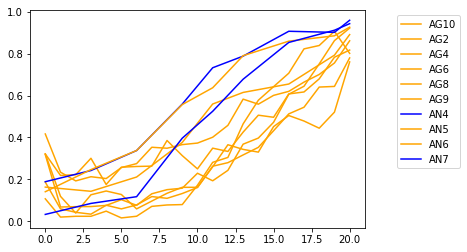

In [966]:
color0='blue'
color1='orange'
fig, ax = pl.subplots()
for animalid, g in counts.groupby(['animalid']):
    if animalid not in pass_animals:
        continue
        
    portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'

    xs = g['morphlevel'].values 
    ys = g[portname]/g['n_trials']
    curr_color = color0 if animalid in mapping[0] else color1
        
    ax.plot(xs, ys, label=animalid, color=curr_color)
ax.legend(bbox_to_anchor=(1.3, 1))



# Fit

In [929]:
# # psychometric function
# def pf(x, alpha, beta):
#     return 1. / (1 + np.exp( -(x-alpha)/beta ))

# def f_weibull(x, alpha, beta, gamma):
#     return (1 - gamma) - (1 - 2*gamma) * np.exp(-((x / alpha)**beta))


# g =counts[counts['animalid']=='AG10'].copy()
# portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'

# xs = g['morphlevel'].values 
# ys = g[portname]/g['n_trials'].astype(float)
# print(xs)

# # fitting
# par0 = scipy.array([0., 1.]) # use some good starting values, reasonable default is [0., 1.]
# par1 = np.array([0.5, 0., 1.0])

# par_e, mcov_e = curve_fit(pf, xs, ys, par0)
# par_w, mcov_w = curve_fit(f_weibull, xs, ys, par1)

# print('Exp:', par_e)
# print('Weib:', par_w)

# fig, ax = pl.subplots()
# ax.plot(xs, ys, 'ko')
# ax.plot(xs, pf(xs, par_e[0], par_e[1]), 'r', label='exp')
# ax.plot(xs, f_weibull(xs, par_w[0], par_w[1], par_w[2]), 'b', label='weibull')
# ax.legend()


In [964]:
mapping

{0: ['AN3', 'AN4', 'AN7'],
 1: ['AG10', 'AG11', 'AG2', 'AG3', 'AG4', 'AG6', 'AG8', 'AG9', 'AN5', 'AN6']}

In [986]:
animalid='AG4'
g = counts[counts['animalid']==animalid]
portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'
xs = g['morphlevel'].values #if animalid in mapping[0] else g['morphlevel'].values[::-1]
ys = g[portname].values / g['n_trials'].astype(float).values
nt = g['n_trials'].values

data = np.vstack((xs, nt, ys))
print(xs, ys)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), array([0.18669528, 0.05882353, 0.04237288, 0.03361345, 0.07627119,
       0.05882353, 0.07758621, 0.11764706, 0.1092437 , 0.1322314 ,
       0.16101695, 0.26271186, 0.27966102, 0.31666667, 0.35294118,
       0.43220339, 0.51282051, 0.54464286, 0.64102564, 0.6440678 ,
       0.78027682]))


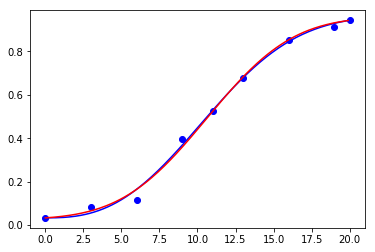

In [1017]:
p_model='erf_psycho_2gammas'
nfits=10

# [threshold, slope, gamma]

if '2gammas' in p_model:
    parstart = np.array([np.mean(data[0, :]), 5, 0.5, 0.5])
    parmin = np.array([np.min(data[0, :]), 0.0, 0., 0.])
    parmax = np.array([np.max(data[0, :]), 10., 1., 1.0])
else:
    parstart = np.array([np.mean(data[0, :]), 5, 0.5])
    parmin = np.array([np.min(data[0, :]), 0.0, 0.])
    parmax = np.array([np.max(data[0, :]), 10., 1.])

fig, ax = pl.subplots()
ax.plot(xs, ys, 'bo', mfc='b')

xvs = np.arange(min(xs), max(xs), 0.1)

# fit
parstart = np.array([np.mean(data[0, :]), 5, 0.5])
parmin = np.array([np.min(data[0, :]), 0.0, 0.])
parmax = np.array([np.max(data[0, :]), 10., 1.])
pars_w, L = mle_fit_psycho(data, p_model='weibull', nfits=10,
                         parstart=parstart, parmin=parmin, parmax=parmax)
ax.plot(xvs, weibull(pars, xvs), '-b')


# fit 2 gamma
parstart = np.array([np.mean(data[0, :]), 5, 0.5, 0.5])
parmin = np.array([np.min(data[0, :]), 0.0, 0., 0.])
parmax = np.array([np.max(data[0, :]), 10., 1., 1.0])
pars_e, L = mle_fit_psycho(data, p_model='erf_psycho_2gammas', nfits=10,
                         parstart=parstart, parmin=parmin, parmax=parmax)
ax.plot(xvs, erf_psycho_2gammas(pars_e, xvs), '-r')

In [927]:
counts.columns

Index([u'Announce_AcquirePort1', u'Announce_AcquirePort3', u'animalid',
       u'failure', u'ignore', u'morphlevel', u'n_trials', u'success'],
      dtype='object')

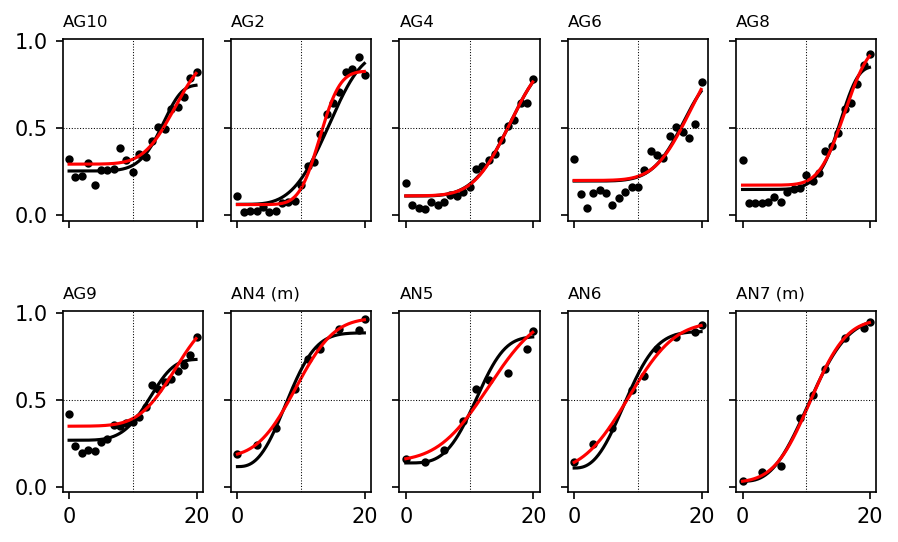

In [1028]:
par0 = sy.array([0., 1.]) # use some good starting values, reasonable default is [0., 1.]
par1 = np.array([0.5, 0.5, 0])

parstart = np.array([np.mean(data[0, :]), 5, (0.5)])
parmin = np.array([np.min(data[0, :]), 0.0, (0.)])
parmax = np.array([np.max(data[0, :]), 10., (1.)])

i=0
d_=[]
fig, axn= pl.subplots(2, 5, figsize=(7, 4), sharex=True, sharey=True, dpi=dpi)
for ai, (animalid, g) in enumerate(counts[counts['animalid'].isin(pass_animals)].groupby(['animalid'])):
    

    portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'
    xs = g['morphlevel'].values #if animalid in mapping[0] else g['morphlevel'].values[::-1]
    ys = g[portname].values / g['n_trials'].astype(float).values
    nt = g['n_trials'].values
    data = np.vstack((xs, nt, ys))

    curr_color = color0 if animalid in mapping[0] else color1
        
    # Fit
    pars, L = mle_fit_psycho(data, p_model='weibull', nfits=10)
    # plot
    ax = axn.flat[ai]
    ax.plot(xs, ys, 'ko',  markersize=3)
    xvs = np.arange(min(xs), max(xs), 0.1)
    ax.plot(xvs, weibull(pars, xvs), '-k', label='mle_%s' % p_model)
    a, b, g1 = pars
    g0 = None
    currd = pd.DataFrame({'animalid': animalid, 'alpha': a, 'beta': b, 'gamma': g1, 
                            'lambda': None, 'model': 'weibull'}, index=[i])
    d_.append(currd)
    i+=1
    
    # fit lapse rate
    p_model2='erf_psycho_2gammas'
    pars_lapse, L = mle_fit_psycho(data, p_model=p_model2, nfits=10)
    ax.plot(xvs, erf_psycho_2gammas(pars_lapse, xvs), '-r', label='mle_%s' % p_model2)
    a, b, g1, g2 = pars_lapse
    currd = pd.DataFrame({'animalid': animalid, 'alpha': a, 'beta': b, 'gamma': g1, 
                            'lambda': g2, 'model': 'erf2'}, index=[i])
    d_.append(currd)
    i+=1
    
    title_str = '%s (m)' % animalid if animalid in mapping[0] else animalid
    ax.set_title(title_str, loc='left', fontsize=8)
    
    ax.axhline(y=0.5, linestyle=':', color='k', linewidth=0.5)
    ax.axvline(x=10, linestyle=':', color='k', linewidth=0.5)
    
pl.subplots_adjust(hspace=0.5, wspace=0.2)

fitdf = pd.concat(d_, axis=0)


In [1030]:
fitdf[fitdf['model']=='erf2']

,alpha,animalid,beta,gamma,lambda,model
1,16.549755,AG10,5.435494,0.292225,0.0633871,erf2
3,12.892613,AG2,3.538153,0.060251,0.174053,erf2
5,16.275371,AG4,6.249233,0.110197,0.0667259,erf2
7,18.205986,AG6,6.146448,0.198756,6.08673e-10,erf2
9,15.994950,AG8,4.417658,0.171878,4.0551e-09,erf2
11,16.604689,AG9,6.266832,0.348046,6.14277e-10,erf2
13,9.144987,AN4,6.711895,0.166765,0.0320639,erf2
15,12.961648,AN5,8.795720,0.145791,4.64898e-09,erf2
17,8.540007,AN6,8.078379,0.082671,0.0540554,erf2
19,10.620185,AN7,6.281241,0.024616,0.0401467,erf2


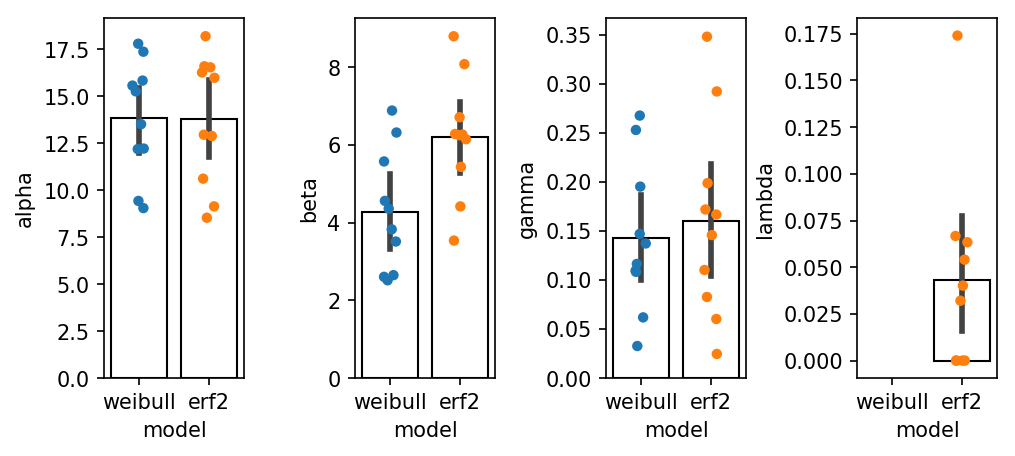

In [1047]:
fit_params = ['alpha', 'beta', 'gamma', 'lambda']
# alpha=shift, beta=slope; gamma
fig, axn = pl.subplots(1,len(fit_params), figsize=(7,4), dpi=dpi)

for ax, param in zip(axn.flat, fit_params):
    sns.stripplot(x='model', y=param, data=fitdf, ax=ax)
    sns.barplot(x='model', y=param, data=fitdf, ax=ax, facecolor='none', edgecolor='k')

pl.subplots_adjust(wspace=0.8, bottom=0.2, top=0.8, left=0.1, right=0.95)

In [1049]:
import pypsignifit

ImportError: No module named pypsignifit

In [1019]:
pars

array([12.22392438,  2.64829025,  0.03269549])

In [1020]:
pars_lapse

array([10.62021678,  6.28123488,  0.02461616,  0.04014654])

In [218]:
df[(df['object']=='2') & (df['outcome']=='success')].groupby(['animalid'])['response'].value_counts()

animalid  response             
AG10      Announce_AcquirePort1    3124
AG11      Announce_AcquirePort1    3011
AG2       Announce_AcquirePort1    2956
AG3       Announce_AcquirePort1    1446
AG4       Announce_AcquirePort1    2759
AG6       Announce_AcquirePort1    3246
AG8       Announce_AcquirePort1    4129
AG9       Announce_AcquirePort1    3390
AN3       Announce_AcquirePort3     841
AN4       Announce_AcquirePort3    2449
AN5       Announce_AcquirePort1    2835
AN6       Announce_AcquirePort1    2298
AN7       Announce_AcquirePort3    3443
Name: response, dtype: int64

In [835]:

df[(df['object']=='2') & (df['outcome']=='success')].groupby(['animalid'])['response'].value_counts()

animalid  response             
AG10      Announce_AcquirePort1    3124
AG11      Announce_AcquirePort1    3011
AG2       Announce_AcquirePort1    2956
AG3       Announce_AcquirePort1    1446
AG4       Announce_AcquirePort1    2759
AG6       Announce_AcquirePort1    3246
AG8       Announce_AcquirePort1    4129
AG9       Announce_AcquirePort1    3390
AN3       Announce_AcquirePort3     841
AN4       Announce_AcquirePort3    2449
AN5       Announce_AcquirePort1    2835
AN6       Announce_AcquirePort1    2298
AN7       Announce_AcquirePort3    3443
Name: response, dtype: int64

In [624]:
df[(df['object']=='1') & (df['outcome']=='failure')].groupby(['animalid'])['response'].value_counts()

animalid  response             
AG10      Announce_AcquirePort1     848
AG11      Announce_AcquirePort1    1810
AG2       Announce_AcquirePort1     565
AG3       Announce_AcquirePort1    1179
AG4       Announce_AcquirePort1     692
AG6       Announce_AcquirePort1    1492
AG8       Announce_AcquirePort1    1535
AG9       Announce_AcquirePort1    1407
AN3       Announce_AcquirePort3     231
AN4       Announce_AcquirePort3     500
AN5       Announce_AcquirePort1     516
AN6       Announce_AcquirePort1     355
AN7       Announce_AcquirePort3     116
Name: response, dtype: int64